# **종합실습_나만의 챗봇 만들기**

* 예비 에이블러들을 위한 QA 챗봇 모델 만들기
    * Vector DB에 데이터 추가하기
    * Retriever, memory, LLM를 연결하기

## **1.환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(langchain)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

* requirements.txt 파일의 [경로 복사]를 한 후,
* 아래 경로에 붙여 넣기

In [2]:
# 경로 : /content/drive/MyDrive/langchain/requirements.txt
# 경로가 다른 경우 아래 코드의 경로 부분을 수정하세요.

!pip install -r /content/drive/MyDrive/langchain/requirements.txt

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### 2) 라이브러리 Import

In [3]:
import pandas as pd
import numpy as np
import os
import sqlite3
from datetime import datetime

import openai

from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage, Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.chains import RetrievalQA, ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### (3) OpenAI API Key 등록
* 환경변수로 key 등록

In [4]:
def load_api_key(filepath):
    with open(filepath, 'r') as file:
        return file.readline().strip()

path = '/content/drive/MyDrive/langchain/'

# API 키 로드 및 환경변수 설정
openai.api_key = load_api_key(path + 'api_key.txt')
os.environ['OPENAI_API_KEY'] = openai.api_key
print(openai.api_key[:15])

sk-proj-mmz5LzR


## **2.Vector DB 만들기**

* 데이터 로딩
    * 제공한 csv 파일의 구조를 그대로 이용
    * 에이블스쿨 홈페이지 FAQ 데이터 수집(https://aivle.kt.co.kr/home/brd/faq/main?mcd=MC00000056)
        * 질문들을 csv 형태로 저장
    * 데이터프레임으로 저장하기

In [24]:
data = pd.read_csv(path + 'aivleschool_qa2.csv', encoding='utf-8')
data

,구분,QA
0,모집/선발,최종 학력 또는 전공과 관계없이 지원할 수 있나요?\nKT 에이블스쿨은 정규 4년제...
1,모집/선발,35세 이상은 지원할 수 없나요?\n본 교육 과정은 34세 이하를 대상으로 하는 교...
2,모집/선발,미취업자의 기준이 뭔가요?\n미취업자의 기준은 아래와 같습니다.\n1) 기간의 정함...
3,모집/선발,"직장인도 지원할 수 있나요?\nKT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시..."
4,모집/선발,아르바이트를 하고 있는데 지원할 수 있나요?\n고용보험에 가입이 되어 있는 경우 1...
...,...,...
64,기타,AICE 시험관련 문의는 어디에 해야하나요?\n\nhelp@aice.study 으로...
65,기타,국민취업지원제도를 신청하고 싶습니다.\n\n국민취업지원제도 신청과 관련 사항은 거주...
66,기타,국민취업지원제도를 안해도 교육 참여되나요?\n\n국민취업제도를 신청하지 않아도 KT...
67,기타,국민취업지원제도 관련 직업훈련탐색표가 필요합니다.\n\n직업훈련탐색표는 고용센터 또...


* 벡터 데이터베이스
    * 기존 벡터 데이터베이스를 그대로 이용
        * Embedding 모델 : text-embedding-ada-002
        * DB 경로 : ./db



In [25]:
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

database = Chroma(persist_directory = path + "./db3",  # 경로 지정(구글 드라이브에서 db 폴더 생성)
                    embedding_function = embeddings)  # 임베딩 벡터로 만들 모델 지정

* 데이터 입력
    * 기존 입력을 모두 제거하고 추가 사항만 모두 입력
    * meta data로 '구분' 칼럼 값 추가하기

In [27]:
ids = database.get()

if ids['ids']: # 기존 입력이 있으면 모두 제거
  database.delete(ids = ids['ids'])

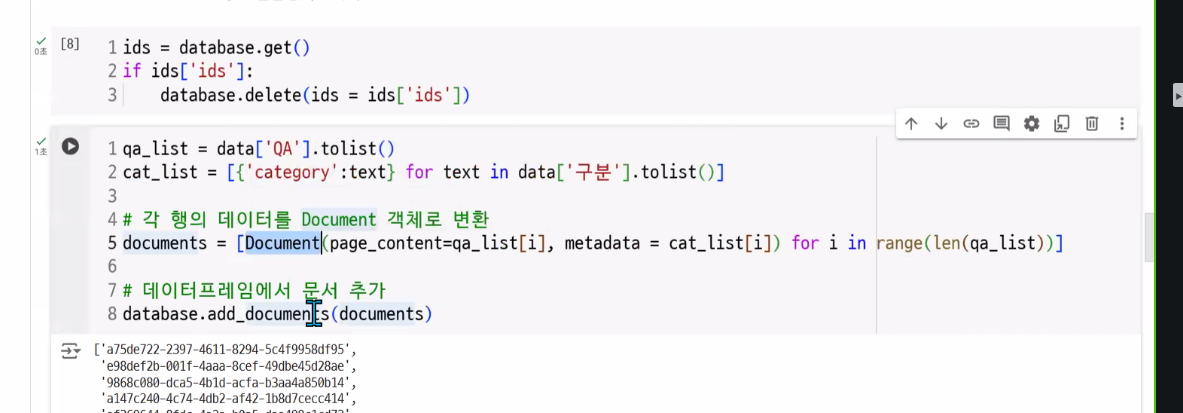

In [33]:
qa_list= data['QA'].tolist()
cat_list = [{'category':text} for text in data['구분'].tolist()]

print(cat_list[0])
#각 행의 데이터를 Document 객체로 변환
documents = [Document(page_content=qa_list[i] ,metadata=cat_list[i]) for i in range(len(qa_list))]

# 데이터프레임에서 문서 추가
database.add_documents(documents)

{'category': '모집/선발'}


['9f09c751-b3ff-4156-b865-d333d2c57e8d',
 'd91aee29-c756-4466-86b9-85861bbab849',
 '9794645f-3055-40d5-8639-4c2fe7f73813',
 'a7ed08f9-7231-418b-8cea-39549412be08',
 'b79902c9-ee36-498d-9d38-6c6d9e9e1f1f',
 'f1fe2882-2375-4017-b889-66dcaa46ee62',
 'f60f7854-0c2d-4696-a781-8f5c9b5312e9',
 '60ceefca-d74b-4ec8-9a73-f3a2644404cb',
 '099d2135-9e2c-4c77-99ad-da36f721e69b',
 '8161edde-891a-4fd0-b8ad-231a48184df0',
 '02ee4110-9880-4da6-9a51-8edd3c225d5b',
 'a2b17e05-6de7-449b-8e99-6b2edd5147e5',
 '117048fe-9a87-4146-942c-be0a642b8917',
 'f1a3ac98-6c74-44d3-83be-a15e23454acd',
 'be1ddc7b-d827-45eb-a248-3bd832903903',
 'dd1c9069-34de-40ef-80ad-35c6cd400987',
 '3a0dfa71-7dab-48ad-be32-7046bc9bb0a4',
 'c9012fce-e0d6-46f2-9223-b1edffe5e097',
 '5179e6b0-ec18-4e9a-bec9-835ad58c8a6b',
 '1091b000-1550-4b68-85b6-1a8c148029f0',
 'bcd517ed-f118-4c8b-9620-fed29b4f8524',
 '5d186a2e-f3b0-468e-af42-bb54df4f4ee4',
 'be3ea530-6e73-4a2d-8a4b-20e66599d7e2',
 '5f835f89-7f5c-4119-8752-5845c1131167',
 'fd8678d6-c350-

* 입력된 데이터 조회

In [29]:
database.get()

{'ids': ['02a00a6a-3844-4c4c-be00-2da8c4dfa16f',
  '0384118d-3e16-419f-b291-62fe68e6253a',
  '059bdcf3-08bb-494a-98c2-ed607089b2d4',
  '088b3664-3e43-443f-bf26-ed2d5bc28944',
  '091262a5-3ba8-4ee5-99b7-2a16d1531e84',
  '098cee4b-8207-4fc8-a3ad-7039c082aed6',
  '0d256ed0-fd9d-42c8-af9c-4d3a2370069b',
  '0f09c177-e91e-4119-aae6-18570dbf149a',
  '138f903d-5001-4f32-bade-e729bf4dace8',
  '19f3c3a2-7c84-42cc-b803-dc8bf447c462',
  '2182f5db-3f1a-4fdb-8331-02e4915fdbed',
  '2452ac98-2933-462f-9e7b-813f64efdcfe',
  '245cdbe9-85f0-4cf5-85fb-33fa33ad2743',
  '2d4f6184-a65e-459c-86a2-327e121f455f',
  '315662b4-3b2e-41dc-8642-30956080207b',
  '33ae960b-0372-413e-a492-2fa457eb8595',
  '38606055-820e-4e89-b3f6-0a0888e69f5e',
  '3881e427-2ea5-4cbe-8209-b8d7c8658883',
  '396ce25c-d970-471b-aa9b-47995ed6e419',
  '3bf32875-9614-4ce9-8bcc-bdea2448e1ea',
  '3ea56727-c6c4-452b-b79b-c7d44298acab',
  '46e147cd-1d2e-4aef-a63a-8083a9c58859',
  '4793d89e-4f5c-4e14-9080-fcec79b2bbee',
  '506636e7-ccc2-4b76-bfb4-

## **3.RAG+LLM모델**

* 모델 : ConversationalRetrievalChain
    * LLM 모델 : gpt-3.5-turbo
    * retriever : 벡터DB
        * 유사도 높은 문서 3개 가져오도록 설정
    * memory 사용

* 모델 선언

In [30]:
# 모델 선언
chat = ChatOpenAI(model="gpt-3.5-turbo")

# 리트리버 선언
k=3
retriever = database.as_retriever(search_kwargs={"k": k}) # vectorDB

# 대화 메모리 생성
memory = ConversationBufferMemory(memory_key="chat_history", input_key="question", output_key="answer",
                                  return_messages=True)

# ConversationalRetrievalQA 체인 생성
qa = ConversationalRetrievalChain.from_llm(llm=chat, retriever=retriever, memory=memory,
                                           return_source_documents=True,  output_key="answer")


* 모델 사용

In [32]:
# 질문

query1 = "내가 부산에사는데 교육 듣는데 지장 없을까?"

# 답변
result = qa(query1)

result['answer']

'부산에 사시는 경우에도 KT 에이블스쿨의 오프라인 교육장소 중 하나인 에이블스쿨 BDIA 동구캠퍼스에서 교육을 들을 수 있습니다. 따라서 부산에 거주하시더라도 교육 듣는 데 지장이 없을 것입니다.'